# Text Classification  
  
O objetivo deste notebook é fazer um estudo sobre a classificação de textos. Serão usadas diversas técnicas para criar um modelo que classifique resumos de teses de doutorado e dissertação de mestrado. Serão usados documentos elaborados por técnicos da Petrobras e outros pertencentes a domínios opostos ao que se é pesquisado na companhia. Esperamos que os modelos classifiquem corretamente os documentos nos seus respectivos domínios.
  
Baseado no post de Shivam Bansa, consultado em 14/08/2019 em:  
https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/ 

In [1]:
#import sys
#sys.path.append("C:\\Users\\upe2\\AppData\\Roaming\\Python\\Python36\\Scripts")

In [2]:
# Importando bibliotecas
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from random import shuffle
import pandas as pd
import numpy as np
import xgboost, textblob, string
from keras.preprocessing import text, sequence
import tensorflow as tf
from keras.models import Sequential
from keras.utils import to_categorical
from keras import layers, models, optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Concatenate
from keras.layers import Layer
from keras.layers import Flatten
import tensorflow as tf
#from keras.layers import Attention
from keras.initializers import get
from bs4 import BeautifulSoup as bs
import nltk
from  nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec

# Preparando os dados

Lendo arquivos JSON com os dados das teses Petrobras no BDTD, das teses no BDTD com assunto "Petroleo" e teses de assunto opostos ao de interesse Petrobras ("Linguas, Letras e Artes", "Arqueologia", "Demografia", ...)

In [3]:
teses_Subject_petroleo = pd.read_json('BDTD/Subject_petroleo.json', orient = 'index')
teses_petrobras_BDTD = pd.read_json('Petrobras/teses_petrobras_BDTD.json', orient = 'index')
tese_area_oposta_Large = pd.read_json('BDTD/teses_areas_opostas_Large.json', orient = 'index')

In [4]:
# Unindo as teses de Petróleo 
teses_petroleo = teses_Subject_petroleo
teses_petroleo = teses_petroleo.append(teses_petrobras_BDTD)
# Excluindo teses duplicadas
teses_petroleo = teses_petroleo[~teses_petroleo.index.duplicated(keep='first')]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Acrescentando a classe nos dois DataFrame

In [5]:
teses_petroleo['classe'] = 'Petroleo'
tese_area_oposta_Large ['classe'] = 'Area Oposta'

Verificando a existência de teses duplicadas nas duas classes

In [6]:
todos = teses_petroleo
todos = todos.append(tese_area_oposta_Large)
len(todos)

8259

In [7]:
todos = todos[~todos.index.duplicated(keep='first')]
len(todos)

8255

In [8]:
teses_petroleo = todos[todos['classe'] == 'Petroleo']
tese_area_oposta_Large = todos[todos['classe'] == 'Area Oposta']

Verificando balanceamento das duas classes

In [9]:
print ('teses_petroleo: ', len(teses_petroleo))
print ('tese_area_oposta: ', len(tese_area_oposta_Large))

teses_petroleo:  2505
tese_area_oposta:  5750


Verificar neceassidade de balancear as classes

Excluindo teses sem resumo em portugues

In [10]:
teses_petroleo = teses_petroleo[(teses_petroleo['Resumo Português:'].notnull())]
tese_area_oposta_Large = tese_area_oposta_Large[(tese_area_oposta_Large['Resumo Português:'].notnull())]

Preprocessando o texto e retirando stopwords

In [11]:
teses_petroleo['Resumo Português:'] = teses_petroleo['Resumo Português:'].str.lower()
tese_area_oposta_Large['Resumo Português:'] = tese_area_oposta_Large['Resumo Português:'].str.lower()

In [5]:
#teses_mesmas_areas_Large['Resumo Português:'] = (teses_mesmas_areas_Large['Resumo Português:'].apply(gensim.utils.simple_preprocess)
#                                                 .str.join(" "))
#tese_area_oposta_Large['Resumo Português:'] = (tese_area_oposta_Large['Resumo Português:'].apply(gensim.utils.simple_preprocess)
#                                               .str.join(" "))

In [ ]:
# Importando as bibliotecas de stopwords
#nltk.download('stopwords')
# Mapeando stopwords com NLTK
#stopwordsIngles = stopwords.words("portuguese")

#def remove_stopwords(abstract):
#    without_stopwords = []
#    for word in abstract:
#        if word not in stopwordsIngles:
#            without_stopwords.append(word)
#    return(without_stopwords)
    
# Excluindo stopwords
#teses_mesmas_areas_Large['Resumo Português:'] = teses_mesmas_areas_Large['Resumo Português:'].apply(remove_stopwords)
#tese_area_oposta_Large['Resumo Português:'] = tese_area_oposta_Large['Resumo Português:'].apply(remove_stopwords)

#Unindo novamente o texto em uma única string
#teses_mesmas_areas_Large['Resumo Português:'] = teses_mesmas_areas_Large['Resumo Português:'].str.join(" ")
#tese_area_oposta_Large['Resumo Português:'] = tese_area_oposta_Large['Resumo Português:'].str.join(" ")

## Dividindo o conjunto de treino, validação e de teste  
  
Vamos dividir os dados em 80% treino e 20% teste

In [12]:
#Função que pega um dataframe com as teses e retorna três dataframes com dados de treino, validação e teste.
#'train' é a fração dos dados para treino, 'valid' é a fração dos dados para validação, o restante é para teste
def train_test(teses, train):
    corte_train = int(round((len(teses)*train),0))
    teses = teses.sample(frac=1)
    teses_train = teses[:corte_train]
    teses_test = teses[corte_train:]
    return(teses_train, teses_test)

In [13]:
teses_petroleo_train, teses_petroleo_test = train_test(teses_petroleo, 0.8)
area_oposta_train, area_oposta_test = train_test(tese_area_oposta_Large, 0.8)

In [14]:
# Train
tese_train = teses_petroleo_train
tese_train = tese_train.append(area_oposta_train)
tese_train = tese_train.sample(frac=1).reset_index(drop=True)

#Test
tese_test = teses_petroleo_test
tese_test = tese_test.append(area_oposta_test)
tese_test = tese_test.sample(frac=1).reset_index(drop=True)

In [15]:
# Separando texto e classe
train_x = tese_train['Resumo Português:']
train_y = tese_train['classe']

test_x = tese_test['Resumo Português:']
test_y = tese_test['classe']

In [16]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y  = encoder.transform(test_y)

In [17]:
print ('Petrobras = ', encoder.transform(['Petroleo'])[0])
print ('Outro = ', encoder.transform(['Area Oposta'])[0])

Petrobras =  1
Outro =  0


# Feature Engineering

The next step is the feature engineering step. In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset. We will implement the following different ideas in order to obtain relevant features from our dataset.  
  
2.1 Count Vectors as features  
2.2 TF-IDF Vectors as features  
* Word level  
* N-Gram level  
* Character level  
  
2.3 Word Embeddings as features  
2.4 Text / NLP based features  
2.5 Topic Models as features  
  
Lets look at the implementation of these ideas in detail.

** 2.1 Count Vectors as features **  
Count Vector is a matrix notation of the dataset in which every row represents a document from the corpus, every column represents a term from the corpus, and every cell represents the frequency count of a particular term in a particular document.

In [18]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(tese_train['Resumo Português:'])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xtest_count =  count_vect.transform(test_x)

**2.2 TF-IDF Vectors as features**  
TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.  
  
TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
IDF(t) = log_e(Total number of documents / Number of documents with term t in it)
  
TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams)
  
**a. Word Level TF-IDF :** Matrix representing tf-idf scores of every term in different documents  
**b. N-gram Level TF-IDF :** N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams  
**c. Character Level TF-IDF :** Matrix representing tf-idf scores of character level n-grams in the corpus

In [19]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(tese_train['Resumo Português:'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xtest_tfidf =  tfidf_vect.transform(test_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(tese_train['Resumo Português:'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(test_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(tese_train['Resumo Português:'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(test_x) 

**2.3 Word Embeddings**  
A word embedding is a form of representing words and documents using a dense vector representation. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. Word embeddings can be trained using the input corpus itself or can be generated using pre-trained word embeddings such as Glove, FastText, and Word2Vec. Any one of them can be downloaded and used as transfer learning. One can read more about word embeddings here.  
  
Following snnipet shows how to use pre-trained word embeddings in the model. There are four essential steps:  
* Loading the pretrained word embeddings
* Creating a tokenizer object
* Transforming text documents to sequence of tokens and pad them
* Create a mapping of token and their respective embeddings

### implementar word2vec

In [20]:
corpus = todos['Resumo Português:']
corpus = corpus.str.cat(sep=' ')

In [21]:
corpus = nltk.sent_tokenize(corpus) # this gives us a list of sentences
shuffle(corpus)

In [22]:
corpus_processado = []
for sentence in corpus:
    corpus_processado.append(word_tokenize(sentence))

In [23]:
BDTD_word2vec_50 = Word2Vec(corpus_processado, size=50, window=10, min_count=1, workers=4, iter=100)

In [24]:
BDTD_word2vec_50.wv['água']

array([-1.9098766 , 11.968972  , -4.1059837 ,  2.241259  ,  5.476759  ,
       -3.326431  , -2.9323068 , -5.9697566 , -0.5712092 , -5.7264986 ,
        1.6771324 , -3.086714  ,  0.6172741 , -4.2382097 ,  3.6244254 ,
       -4.051501  ,  5.540959  , -4.816349  , -2.4216197 , -2.9671602 ,
        2.058387  ,  4.141417  ,  1.1503296 , -0.5761935 ,  0.9338799 ,
       -3.1845746 ,  1.1375757 ,  7.9121804 , -6.157035  , -0.5634386 ,
       -1.4929172 , -6.0675507 ,  2.9826338 , -4.1554537 , -1.7398705 ,
       -5.9444547 ,  8.148489  ,  1.6487848 ,  2.0393517 ,  0.9067678 ,
       -2.7536535 ,  1.8059425 ,  9.502411  ,  3.3586488 ,  3.316077  ,
       -3.3818624 ,  0.16718933,  0.2930071 , -4.743617  , -0.08311045],
      dtype=float32)

In [25]:
BDTD_word2vec_50.wv.similar_by_word('água')

[('vazão', 0.735665500164032),
 ('solo', 0.7263180017471313),
 ('óleo', 0.7200117111206055),
 ('salmoura', 0.7131927609443665),
 ('temperatura', 0.6893408894538879),
 ('areia', 0.6845296621322632),
 ('atmosfera', 0.6763578653335571),
 ('armazenamento', 0.6651514172554016),
 ('coluna', 0.6558036804199219),
 ('mistura', 0.6535024046897888)]

In [26]:
# Import Embedding trained model
#BDTD_word2vec_300 = Word2Vec.load("Embeddings\BDTD_word2vec_300")

In [27]:
word2index = {}
for index, word in enumerate(BDTD_word2vec_50.wv.index2word):
    word2index[word] = index

In [28]:
def index_pad_text(text, maxlen, word2index):
    maxlen = 400
    new_text = [] 
    for sent in text:
        temp_sent = []
        for word in word_tokenize(sent):
            try:
                temp_sent.append(word2index[word])
            except:
                pass
        # Add the padding for each sentence. Here I am padding with 0
        if len(temp_sent) > maxlen:
            temp_sent = temp_sent[:400]
        else:
            temp_sent += [0] * (maxlen - len(temp_sent))
        new_text.append(temp_sent)

    return np.array(new_text)

maxlen = 400
train_seq_x = index_pad_text(train_x, maxlen, word2index)
test_seq_x = index_pad_text(test_x, maxlen, word2index)

In [36]:
word2index['estudamos']

10400

In [34]:
test_x[2]

'no presente trabalho, estudamos as relações entre a literatura e o sagrado, analisando esta interlocução em poemas malditos, gozosos e devotos (1984) e sobre a tua grande face (1986), de hilda hilst, e verificando como se dá o processo de humanização do divino nas obras em questão. analisamos também as formas de aproximação do eu lírico para com o ser divino, bem como a importância do erotismo para a construção de uma imagem metafísico-religiosa. como corpus, analisamos oito poemas hilstianos sendo quatro de cada obra e como resultado, constatamos que a humanização do divino se faz, sobretudo, através da palavra e da caracterização humana conferida a deus. em poemas malditos, gozosos e devotos (1984), o sagrado aparece, dentre outras formas, através de apóstrofes a deus, mas se mostra, principalmente, pela revelação do ser divino enquanto uma entidade sagrada, soberana aos seres humanos. para a realização desta pesquisa, utilizamos como aparato teórico as teorias de mircea eliade (201

In [35]:
test_seq_x[2]

array([    20,     89,     44,      0,  10400,     19,    225,     41,
            4,    356,      3,      5,   3539,      0,   3209,    206,
        15358,     13,   6480,  60790,      0,  60791,      3,  15253,
           10,   8821,      9,      3,     49,      4,  34703,    213,
         1759,     10,   7146,      9,      0,      1,      0,      3,
         4892,     24,     39,   2415,      5,     67,      1,   3933,
            7,  16572,     56,   1019,     13,    612,      2,   3953,
           85,     19,    437,      1,   2488,      7,   4515,  17032,
           16,     15,      5,     65,  16572,      0,    124,     24,
            4,    277,      7,  25332,     16,      4,    241,      1,
           26,   1484, 121481,      2,     24,   2176,      0,   3953,
         1128,   6480, 109376,     78,    284,      1,    113,    642,
            3,     24,    516,      0,  10814,     11,      4,   3933,
            7,  16572,     39,    961,      0,   1318,      0,     81,
      

In [34]:
#BDTD_word2vec_50.wv.get_keras_embedding(train_embeddings=False)

**2.4 Text / NLP based features**  
A number of extra text based features can also be created which sometimes are helpful for improving text classification models. Some examples are:  
  
1 Word Count of the documents – total number of words in the documents  
2 Character Count of the documents – total number of characters in the documents  
3 Average Word Density of the documents – average length of the words used in the documents  
4 Puncutation Count in the Complete Essay – total number of punctuation marks in the documents  
5 Upper Case Count in the Complete Essay – total number of upper count words in the documents  
6 Title Word Count in the Complete Essay – total number of proper case (title) words in the documents  
7 Frequency distribution of Part of Speech Tags:  
* Noun Count  
* Verb Count  
* Adjective Count
* Adverb Count
* Pronoun Count
  
These features are highly experimental ones and should be used according to the problem statement only.

In [34]:
tese_train['char_count'] = tese_train['Resumo Português:'].apply(len)
tese_train['word_count'] = tese_train['Resumo Português:'].apply(lambda x: len(x.split()))
tese_train['word_density'] = tese_train['char_count'] / (tese_train['word_count']+1)
tese_train['punctuation_count'] = (tese_train['Resumo Português:'].
                                   apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))) 
tese_train['title_word_count'] = (tese_train['Resumo Português:'].
                                  apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()])))
tese_train['upper_case_word_count'] = (tese_train['Resumo Português:'].
                                       apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()])))

**Accessing the MacMorpho Tagged Corpus**  
NLTK includes the MAC-MORPHO Brazilian Portuguese POS-tagged news text, with over a million words of journalistic texts extracted from ten sections of the daily newspaper Folha de Sao Paulo, 1994.
  
We can access this corpus as a sequence of words or tagged words as follows:

In [35]:
import nltk.corpus
#nltk.download('mac_morpho')
nltk.corpus.mac_morpho.words()
#['Jersei', 'atinge', 'm\xe9dia', 'de', 'Cr$', '1,4', ...]
nltk.corpus.mac_morpho.sents() # doctest: +NORMALIZE_WHITESPACE
#[['Jersei', 'atinge', 'm\xe9dia', 'de', 'Cr$', '1,4', 'milh\xe3o',
#'em', 'a', 'venda', 'de', 'a', 'Pinhal', 'em', 'S\xe3o', 'Paulo'],
#['Programe', 'sua', 'viagem', 'a', 'a', 'Exposi\xe7\xe3o', 'Nacional',
#'do', 'Zebu', ',', 'que', 'come\xe7a', 'dia', '25'], ...]
nltk.corpus.mac_morpho.tagged_words()
#[('Jersei', 'N'), ('atinge', 'V'), ('m\xe9dia', 'N'), ...]
nltk.corpus.mac_morpho.tagged_sents()[100]

[('Bezerra', 'NPROP'),
 ('diz', 'V'),
 ('que', 'KS'),
 ('está', 'VAUX'),
 ('articular', 'V'),
 ('uma', 'ART'),
 ('ação', 'N'),
 ('conjunta', 'ADJ'),
 ('de', 'PREP|+'),
 ('o', 'ART'),
 ('com', 'PREP'),
 ('os', 'ART'),
 ('governos', 'N'),
 ('de', 'PREP|+'),
 ('os', 'ART'),
 ('três', 'NUM'),
 ('Estados', 'N'),
 ('para', 'PREP'),
 ('controlar', 'V'),
 ('a', 'ART'),
 ('praga', 'N')]

**Accessing the Floresta Portuguese Treebank**  
The NLTK data distribution includes the "Floresta Sinta(c)tica Corpus" version 7.4, available from http://www.linguateca.pt/Floresta/.
  
We can access this corpus as a sequence of words or tagged words as follows:

In [36]:
from nltk.corpus import floresta
floresta.words()
floresta.tagged_words()

[('Um', '>N+art'), ('revivalismo', 'H+n'), ...]

The tags consist of some syntactic information, followed by a plus sign, followed by a conventional part-of-speech tag. Let's strip off the material before the plus sign:

In [37]:
def simplify_tag(t):
    if "+" in t:
        return t[t.index("+")+1:]
    else:
        return t
twords = floresta.tagged_words()
twords = [(w.lower(), simplify_tag(t)) for (w,t) in twords]
twords[:10]
#[('um', 'art'), ('revivalismo', 'n'), ('refrescante', 'adj'), ('o', 'art'), ('7_e_meio', 'prop'),
#('\xe9', 'v-fin'), ('um', 'art'), ('ex-libris', 'n'), ('de', 'prp'), ('a', 'art')]

[('um', 'art'),
 ('revivalismo', 'n'),
 ('refrescante', 'adj'),
 ('o', 'art'),
 ('7_e_meio', 'prop'),
 ('é', 'v-fin'),
 ('um', 'art'),
 ('ex-libris', 'n'),
 ('de', 'prp'),
 ('a', 'art')]

**Part-of-Speech Tagging**

In [38]:
# Let's begin by getting the tagged sentence data, and simplifying the tags as described earlier.
tsents = floresta.tagged_sents()
tsents = [[(w.lower(),simplify_tag(t)) for (w,t) in sent] for sent in tsents if sent]
train = tsents[1000:]
test = tsents[:1000]

In [39]:
#We already know that n is the most common tag, so we can set up a default tagger that tags every word as a noun, and see how well it does:
tagger0 = nltk.DefaultTagger('n')
print ('tagger0 (every word noun) = ', tagger0.evaluate(test))
#nltk.tag.api.evaluate(tagger0, test)
#0.17697228144989338

#Evidently, about one in every six words is a noun. Let's improve on this by training a unigram tagger:
tagger1 = nltk.UnigramTagger(train, backoff=tagger0)
print('tagger1 - Unigram = ', tagger1.evaluate(test))
#nltk.tag.accuracy(tagger1, test)
#0.87029140014214645

#Next a bigram tagger:
tagger2 = nltk.BigramTagger(train, backoff=tagger1)
print('tagger2 Bigram = ', tagger2.evaluate(test))
#nltk.tag.accuracy(tagger2, test)
#0.89019189765458417

tagger0 (every word noun) =  0.17800040072129833
tagger1 - Unigram =  0.8740532959326788
tagger2 Bigram =  0.8900420757363254


In [40]:
pos_family = {
    'noun' : ['n'],
    'adj' :  ['adj'],
    'art' : ['art'],
    'pron' : ['pron-det', 'pron-indp', 'pron-pers', 'prop'],
    'num': ['num'],
    'verb' : ['v-fin','v-ger', 'v-inf', 'v-pcp'],
    'adv' : ['adv'],
    'prp': ['prp'],
    'conj' : ['conj-c', 'conj-s'],
    'in' : ['in'],
    'ec' : ['ec']
}

# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        for tup in tagger2.tag(x):
            if tup[1] in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

tese_train['noun_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'noun'))
tese_train['adj_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'adj'))
tese_train['art_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'art'))
tese_train['pron_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'pron'))
tese_train['num_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'num'))
tese_train['verb_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'verb'))
tese_train['adv_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'adv'))
tese_train['prp_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'prp'))
tese_train['conj_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'conj'))
tese_train['in_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'in'))
tese_train['ec_count'] = tese_train['Resumo Português:'].apply(lambda x: check_pos_tag(x, 'ec'))

In [41]:
tese_train.head()

,Assuntos em Inglês:,Assuntos em Portugês:,Autor/a:,Banca:,Citação:,Co-advisor:,Data de Defesa:,Departamento:,Download Texto Completo:,Idioma:,...,adj_count,art_count,pron_count,num_count,verb_count,adv_count,prp_count,conj_count,in_count,ec_count
0,"[Eletric stimulation therapy, Interferential c...","[Fisiologia, Eletroterapia, Correntes elétrica...","\n\n Cruz, Kamilla Mayara Lucas da\n\n",NaN,"CRUZ, Kamilla Mayara Lucas da. O efeito antino...",NaN,2014,NaN,https://ri.ufs.br/handle/riufs/3981,por,...,186,186,308,0,0,0,247,183,0,0
1,[scalle free lattice],[rede sem escala],"\n\n Batista, Carlos Adalberto Schnaide...","\n\n Viana, Ricardo Luiz\n\n, \n\n ...","BATISTA, Carlos Adalberto Schnaider. Sincroniz...",NaN,2007,\nFisica\n\n,http://tede2.uepg.br/jspui/handle/prefix/913,por,...,63,99,177,0,3,0,106,134,4,0
2,"[Reproduction, Testicular morphometry, Ouratea...","[Reprodução, Morfometria testicular, Raiz de b...","\n\n Matta, Ana Paula de Lima Florentin...","\n\n Neves, Clóvis Andrade\n\n, \n\n ...","MATTA, Ana Paula de Lima Florentino. Effects o...","\n\n Leite, João Paulo Viana\n\n, \n\n ...",2008,\nAnálises quantitativas e moleculares do Geno...,http://locus.ufv.br/handle/123456789/2307,por,...,93,172,286,0,2,0,153,181,10,0
3,"[Migration, Life quality, Federal servers]","[Emigração, Qualidade de vida, Servidores públ...","\n\n Francisco, Arnaldo\n\n","\n\n Silva, Douglas Mansur da\n\n, \n\n...","FRANCISCO, Arnaldo. Migration and life quality...","\n\n Loreto, Maria das Dores Saraiva de...",2011,\nEconomia familiar; Estudo da família; Teoria...,http://locus.ufv.br/handle/123456789/3336,por,...,215,231,518,0,3,0,318,305,6,0
4,"[Culicid, Intraspecific, Competition, Size, Diet]","[Culicídeo, Intraespecífica, Competição, Taman...","\n\n Felchicher, Francielly",NaN,"FELCHICHER, Francielly. Influência da densidad...","\n\n Vianna, Élvia Elena Silveira\n\n",2013,\nBiologia\n\n,http://repositorio.ufpel.edu.br/handle/ri/2333,por,...,144,181,321,0,3,0,228,204,5,0


**2.5 Topic Models as features**  
Topic Modelling is a technique to identify the groups of words (called a topic) from a collection of documents that contains best information in the collection. I have used Latent Dirichlet Allocation for generating Topic Modelling Features. LDA is an iterative model which starts from a fixed number of topics. Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics. Although the tokens themselves are meaningless, the probability distributions over words provided by the topics provide a sense of the different ideas contained in the documents. One can read more about topic modelling here

In [42]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=30, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

In [43]:
# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

In [44]:
topic_summaries

['gi vd ta pupas sitos officinalis polifenóis ractopamina carv iatf',
 'grupo grupos corporal animais controle sm risco exercício gordura arterial',
 'leprosy ndo lid ufrpe bas tocolytic nthf enxerto emáx hsa',
 'embriões wind oócitos bcl logos gli tca part descartado laminado',
 'vs alimenta respiratórios bode sgrq tático espirometria breathing volume snip',
 'de do da os com que em para no as',
 'the of and in to with for de was that',
 'materiais resistência material propriedades ensaios dental mecânicas tração compósitos mm',
 'la el en los de las del le eu un',
 'festa lv atletas memória kt sedentário vl festas cpt inspeção',
 'dys cateter aflatoxinas enteritidis estocagem camarosa filés gmd mr gelo',
 'platensis gos tds bagasse apl ids bai orégano rat imagination',
 'silagens moringa rpaj ensilagem ndt pradj rebrotação artificialmente trematódeo lpa',
 'bacia rio área água região ambiental sub norte hidrográfica eventos',
 'deus gica dança justi jornalismo acústica sica metaf caf

**3. Model Building**  
The final step in the text classification framework is to train a classifier using the features created in the previous step. There are many different choices of machine learning models which can be used to train a final model. We will implement following different classifiers for this purpose:  
 
* Naive Bayes Classifier
* Linear Classifier
* Support Vector Machine
* Bagging Models
* Boosting Models
* Shallow Neural Networks
* Deep Neural Networks
* Convolutional Neural Network (CNN)
* Long Short Term Modelr (LSTM)
* Gated Recurrent Unit (GRU)
* Bidirectional RNN
* Recurrent Convolutional Neural Network (RCNN)
* Other Variants of Deep Neural Networks  

Lets implement these models and understand their details. The following function is a utility function which can be used to train a model. It accepts the classifier, feature_vector of training data, labels of training data and feature vectors of valid data as inputs. Using these inputs, the model is trained and accuracy score is computed.

In [37]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, is_neural_net=False):
    # fit the training dataset on the classifier
    
    if is_neural_net:
        callbacks = EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True)
        history = classifier.fit(feature_vector_train,
                                 label, #to_categorical(label),
                                 epochs=1000,
                                 batch_size=64,
                                 validation_split=0.25,
                                 callbacks=[callbacks])
        
    # plot the loss
        # list all data in history
        print(history.history.keys())
        # summarize history for loss
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model acc')
        plt.ylabel('acc')
        plt.xlabel('epoch')
        plt.legend(['acc', 'val_acc'], loc='upper left')
        plt.show()
        
    else:
        classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    predictions = np.rint(predictions)
    
    #if is_neural_net:
    #    predictions = np.rint(predictions)
        
    #predictions = classifier.predict(feature_vector_test)
    #predictions_arr = tf.argmax(predictions, axis = 1)
    
    num_classes = 2
    return (metrics.accuracy_score(predictions, test_y),
            tf.confusion_matrix(predictions, test_y, num_classes))

**3.1 Naive Bayes**  
Implementing a naive bayes model using sklearn implementation with different features  
  
Naive Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature here .

In [38]:
# Naive Bayes on Count Vectors
accuracy, confusion = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xtest_count)
print ("NB, Count Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# Naive Bayes on Word Level TF IDF Vectors
accuracy, confusion = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xtest_tfidf)
print ("NB, WordLevel TF-IDF Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())
    
# Naive Bayes on Ngram Level TF IDF Vectors
accuracy, confusion = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())
    
# Naive Bayes on Character Level TF IDF Vectors
accuracy, confusion = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xtest_tfidf_ngram_chars)
print ("NB, CharLevel Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

NB, Count Vectors:  0.9445137157107232
[[1105   44]
 [  45  410]]
NB, WordLevel TF-IDF Vectors:  0.9345386533665836
[[1113   68]
 [  37  386]]
NB, N-Gram Vectors:  0.928927680798005
[[1113   77]
 [  37  377]]
NB, CharLevel Vectors:  0.9120947630922693
[[1132  123]
 [  18  331]]


**3.2 Linear Classifier**  
Implementing a Linear Classifier (Logistic Regression)  
  
Logistic regression measures the relationship between the categorical dependent variable and one or more independent variables by estimating probabilities using a logistic/sigmoid function. One can read more about logistic regression here

In [39]:
# Linear Classifier on Count Vectors
accuracy, confusion = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xtest_count)
print ("LR, Count Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# Linear Classifier on Word Level TF IDF Vectors
accuracy, confusion = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xtest_tfidf)
print ("LR, WordLevel TF-IDF Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy, confusion = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# Linear Classifier on Character Level TF IDF Vectors
accuracy, confusion = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xtest_tfidf_ngram_chars)
print ("LR, CharLevel Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR, Count Vectors:  0.9569825436408977
[[1138   57]
 [  12  397]]
LR, WordLevel TF-IDF Vectors:  0.9438902743142145
[[1137   77]
 [  13  377]]
LR, N-Gram Vectors:  0.9370324189526185
[[1143   94]
 [   7  360]]
LR, CharLevel Vectors:  0.9326683291770573
[[1138   96]
 [  12  358]]


**3.3 Implementing a SVM Model**  
Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. The model extracts a best possible hyper-plane / line that segregates the two classes. One can read more about it here

In [40]:
# SVM on Count Vectors
accuracy, confusion = train_model(svm.SVC(gamma='scale'), xtrain_count, train_y, xtest_count)
print ("SVM, Count Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# SVM on Word Level TF IDF Vectors
accuracy, confusion = train_model(svm.SVC(gamma='scale'), xtrain_tfidf, train_y, xtest_tfidf)
print ("SVM, Word Level TF IDF Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# SVM on Ngram Level TF IDF Vectors
accuracy, confusion = train_model(svm.SVC(gamma='scale'), xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram)
print ("SVM, Ngram Level TF IDF Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# SVM on Character Level TF IDF Vectors
accuracy, confusion = train_model(svm.SVC(gamma='scale'), xtrain_tfidf_ngram_chars, train_y, xtest_tfidf_ngram_chars)
print ("SVM, Character Level TF IDFs Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

SVM, Count Vectors:  0.9413965087281796
[[1143   87]
 [   7  367]]
SVM, Word Level TF IDF Vectors:  0.9607231920199502
[[1141   54]
 [   9  400]]
SVM, Ngram Level TF IDF Vectors:  0.9457605985037406
[[1144   81]
 [   6  373]]
SVM, Character Level TF IDFs Vectors:  0.9582294264339152
[[1141   58]
 [   9  396]]


**3.4 Bagging Model**  
Implementing a Random Forest Model  
  
Random Forest models are a type of ensemble models, particularly bagging models. They are part of the tree based model family. One can read more about Bagging and random forests here

In [41]:
# RF on Count Vectors
accuracy, confusion = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xtest_count)
print ("RF, Count Vectors Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# RF on Word Level TF IDF Vectors
accuracy, confusion = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xtest_tfidf)
print ("RF, WordLevel TF-IDF Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# RF on Ngram Level TF IDF Vectors
accuracy, confusion = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram)
print ("RF, Ngram Level TF IDF Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# RF on Character Level TF IDF Vectors
accuracy, confusion = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram_chars, train_y, xtest_tfidf_ngram_chars)
print ("RF, Character Level TF IDFs Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, Count Vectors Vectors:  0.9233167082294265
[[1137  110]
 [  13  344]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, WordLevel TF-IDF Vectors:  0.9432668329177057
[[1132   73]
 [  18  381]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, Ngram Level TF IDF Vectors:  0.9420199501246883
[[1132   75]
 [  18  379]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF, Character Level TF IDFs Vectors:  0.928927680798005
[[1146  110]
 [   4  344]]


**3.5 Boosting Model**  
Implementing Xtereme Gradient Boosting Model  
  
Boosting models are another type of ensemble models part of tree based models. Boosting is a machine learning ensemble meta-algorithm for primarily reducing bias, and also variance in supervised learning, and a family of machine learning algorithms that convert weak learners to strong ones. A weak learner is defined to be a classifier that is only slightly correlated with the true classification (it can label examples better than random guessing). Read more about these models here

In [42]:
# Extereme Gradient Boosting on Count Vectors
accuracy, confusion = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xtest_count.tocsc())
print ("Xgb, Count Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy, confusion = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xtest_tfidf.tocsc())
print ("Xgb, WordLevel TF-IDF: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# Extereme Gradient Boosting on Ngram Level TF IDF Vectors
accuracy, confusion = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram.tocsc(), train_y, xtest_tfidf_ngram.tocsc())
print ("Xgb, Ngram Level Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy, confusion = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xtest_tfidf_ngram_chars.tocsc())
print ("Xgb, CharLevel Vectors: ", accuracy)
with tf.Session() as sess:
    print(confusion.eval())

Xgb, Count Vectors:  0.9476309226932669
[[1143   77]
 [   7  377]]
Xgb, WordLevel TF-IDF:  0.9457605985037406
[[1143   80]
 [   7  374]]
Xgb, Ngram Level Vectors:  0.9239401496259352
[[1149  121]
 [   1  333]]
Xgb, CharLevel Vectors:  0.9507481296758105
[[1144   73]
 [   6  381]]


**3.6 Shallow Neural Networks**  
A neural network is a mathematical model that is designed to behave similar to biological neurons and nervous system. These models are used to recognize complex patterns and relationships that exists within a labelled data. A shallow neural network contains mainly three types of layers – input layer, hidden layer, and output layer. Read more about neural networks here

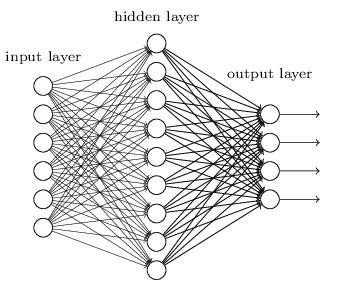






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 4809 samples, validate on 1604 samples
Epoch 1/1000
4809/4809 [==============================] - 23s 5ms/step - loss: 0.2381 - acc: 0.9177 - val_loss: 0.1569 - val_acc: 0.9545
Epoch 2/1000
4809/4809 [==============================] - 16s 3ms/step - loss: 0.0675 - acc: 0.9834 - val_loss: 0.1486 - val_acc: 0.9570
Epoch 3/1000
4809/4809 [==============================] - 17s 3ms/step - loss: 0.0279 - acc: 0.9960 - val_loss: 0.1300 - val_acc: 0.9595
Epoch 4/1000
4809/4809 [==============================] - 17s 3ms/step - loss: 0.0145 - acc: 0.9996 - val_loss: 0.1338 - val_acc: 0.9613
Epoch 5/1000
4809/4809 [==============================] - 17s 3ms/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.1409 - val_acc: 0.9620
Epoch 6/1000
4809/4809 [==============================] - 17s 3ms/step - loss: 0.0071 - acc: 1.0000 - val_loss: 0.1458 - val_acc: 0.9613
Epoch 7/1000
4809/4809 [======

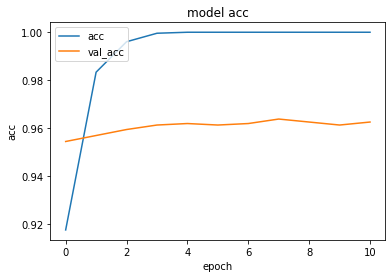

Shallow Neural Network on Count Vectors Vectors 0.956359102244389
[[1130   50]
 [  20  404]]
Train on 4809 samples, validate on 1604 samples
Epoch 1/1000
4809/4809 [==============================] - ETA: 0s - loss: 0.5467 - acc: 0.716 - 2s 354us/step - loss: 0.5453 - acc: 0.7159 - val_loss: 0.4850 - val_acc: 0.7201
Epoch 2/1000
4809/4809 [==============================] - 1s 250us/step - loss: 0.4324 - acc: 0.7804 - val_loss: 0.3811 - val_acc: 0.8585
Epoch 3/1000
4809/4809 [==============================] - 1s 254us/step - loss: 0.3266 - acc: 0.8985 - val_loss: 0.2937 - val_acc: 0.9190
Epoch 4/1000
4809/4809 [==============================] - 1s 278us/step - loss: 0.2455 - acc: 0.9345 - val_loss: 0.2384 - val_acc: 0.9339
Epoch 5/1000
4809/4809 [==============================] - 1s 266us/step - loss: 0.1941 - acc: 0.9505 - val_loss: 0.2067 - val_acc: 0.9439
Epoch 6/1000
4809/4809 [==============================] - 1s 263us/step - loss: 0.1611 - acc: 0.9599 - val_loss: 0.1876 - val_acc: 

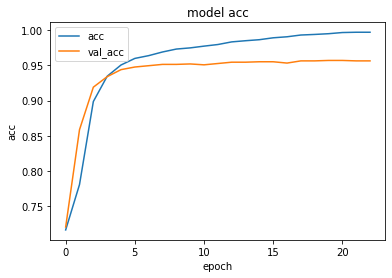

Shallow Neural Network on Word Level TF IDF Vectors 0.9532418952618454
[[1127   52]
 [  23  402]]
Train on 4809 samples, validate on 1604 samples
Epoch 1/1000
4809/4809 [==============================] - 2s 334us/step - loss: 0.5793 - acc: 0.6635 - val_loss: 0.4970 - val_acc: 0.7207
Epoch 2/1000
4809/4809 [==============================] - 1s 237us/step - loss: 0.4519 - acc: 0.7544 - val_loss: 0.4120 - val_acc: 0.8367
Epoch 3/1000
4809/4809 [==============================] - 1s 237us/step - loss: 0.3655 - acc: 0.8702 - val_loss: 0.3387 - val_acc: 0.9015
Epoch 4/1000
4809/4809 [==============================] - 1s 240us/step - loss: 0.2930 - acc: 0.9172 - val_loss: 0.2844 - val_acc: 0.9327
Epoch 5/1000
4809/4809 [==============================] - 1s 237us/step - loss: 0.2394 - acc: 0.9368 - val_loss: 0.2462 - val_acc: 0.9320
Epoch 6/1000
4809/4809 [==============================] - 1s 240us/step - loss: 0.2007 - acc: 0.9453 - val_loss: 0.2216 - val_acc: 0.9327
Epoch 7/1000
4809/4809 [==

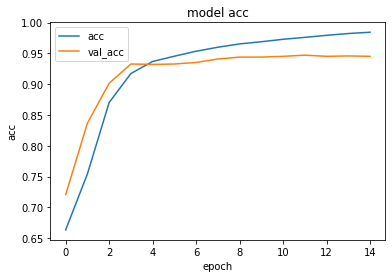

Shallow Neural Network on Ngram Level TF IDF Vectors 0.9407730673316709
[[1126   71]
 [  24  383]]
Train on 4809 samples, validate on 1604 samples
Epoch 1/1000
4809/4809 [==============================] - 2s 347us/step - loss: 0.5733 - acc: 0.6825 - val_loss: 0.4996 - val_acc: 0.7213
Epoch 2/1000
4809/4809 [==============================] - 1s 250us/step - loss: 0.4624 - acc: 0.7615 - val_loss: 0.4139 - val_acc: 0.8298
Epoch 3/1000
4809/4809 [==============================] - 1s 260us/step - loss: 0.3749 - acc: 0.8665 - val_loss: 0.3366 - val_acc: 0.8959
Epoch 4/1000
4809/4809 [==============================] - 1s 266us/step - loss: 0.3015 - acc: 0.9087 - val_loss: 0.2789 - val_acc: 0.9264
Epoch 5/1000
4809/4809 [==============================] - 1s 260us/step - loss: 0.2473 - acc: 0.9308 - val_loss: 0.2405 - val_acc: 0.9333
Epoch 6/1000
4809/4809 [==============================] - 1s 291us/step - loss: 0.2112 - acc: 0.9412 - val_loss: 0.2169 - val_acc: 0.9389
Epoch 7/1000
4809/4809 [=

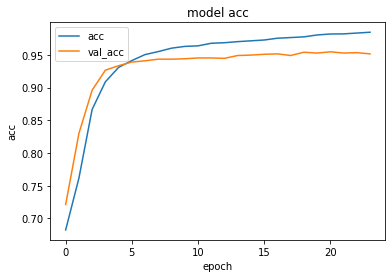

Shallow Neural Network on Character Level TF IDF Vectors 0.9526184538653366
[[1131   57]
 [  19  397]]


In [43]:
def create_model_architecture(input_size):
    # create input layer 
    #input_layer = layers.Input((input_size, ), sparse=True)
    model = Sequential()
    
    # create hidden layer
    model.add(layers.Dense(100,
                           input_shape=(input_size, ),
                           activation="sigmoid"))
    #hidden_layer = layers.Dense(100, activation="relu")(input_layer)
    
    # create output layer
    model.add(layers.Dense(1, activation='sigmoid')) 
    #output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    opt = optimizers.Adam()
    #classifier = models.Model(inputs = input_layer, outputs = output_layer)
    #classifier.compile(optimizer=opt, loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
    #model.summary()
    #classifier.summary()
    return model #classifier 

num_classes = 1

# Shallow Neural Network on Count Vectors Vectors
classifier = create_model_architecture(xtrain_count.shape[1])
accuracy, confusion = train_model(classifier, xtrain_count, train_y, xtest_count, is_neural_net=True)
print ("Shallow Neural Network on Count Vectors Vectors",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())


# Shallow Neural Network on Word Level TF IDF Vectors
classifier = create_model_architecture(xtrain_tfidf.shape[1])
accuracy, confusion = train_model(classifier, xtrain_tfidf, train_y, xtest_tfidf, is_neural_net=True)
print ("Shallow Neural Network on Word Level TF IDF Vectors",  accuracy,)
with tf.Session() as sess:
    print(confusion.eval())

# Shallow Neural Network on Ngram Level TF IDF Vectors
classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1])
accuracy, confusion = train_model(classifier, xtrain_tfidf_ngram, train_y, xtest_tfidf_ngram, is_neural_net=True)
print ("Shallow Neural Network on Ngram Level TF IDF Vectors",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())


# Shallow Neural Network on Character Level TF IDF Vectors
classifier = create_model_architecture(xtrain_tfidf_ngram_chars.shape[1])
accuracy, confusion = train_model(classifier, xtrain_tfidf_ngram_chars, train_y, xtest_tfidf_ngram_chars, is_neural_net=True)
print ("Shallow Neural Network on Character Level TF IDF Vectors",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())

**3.7 Deep Neural Networks**  
Deep Neural Networks are more complex neural networks in which the hidden layers performs much more complex operations than simple sigmoid or relu activations. Different types of deep learning models can be applied in text classification problems.
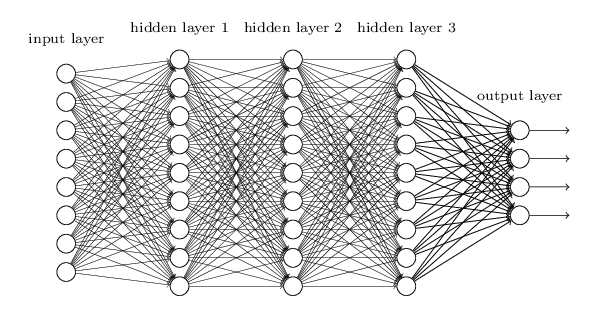

**3.7.1 Convolutional Neural Network**  
In Convolutional neural networks, convolutions over the input layer are used to compute the output. This results in local connections, where each region of the input is connected to a neuron in the output. Each layer applies different filters and combines their results.  
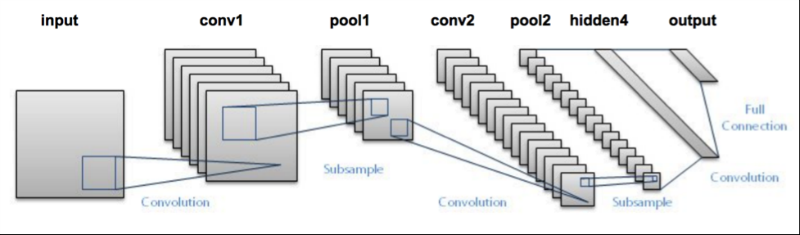

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 400, 50)           6784550   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 400, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 396, 128)          32128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 198, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 198, 128)          0         
__________________________

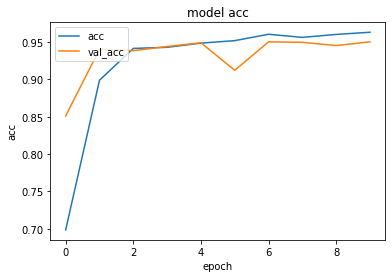

CNN, Word Embeddings 0.9532418952618454
[[1131   56]
 [  19  398]]


In [44]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((maxlen, ))

    # Add the word embedding Layer
    embedding_layer = BDTD_word2vec_50.wv.get_keras_embedding(train_embeddings=True)(input_layer)
    #embedding_layer.mask_zero = True  # No need for a masking layer
    
    
    
    #embedding_layer = layers.Embedding(len(word_index) + 1,
    #                                   emb_dimension,
    #                                   weights=[embedding_matrix],
    #                                   trainable=False)(input_layer)
    
    embedding_layer = layers.SpatialDropout1D(0.05)(embedding_layer)

    # Add the convolutional Layer e pooling layer
    conv_layer_1 = layers.Convolution1D(128, 5, activation="relu")(embedding_layer)
    pooling_layer_1 = layers.MaxPooling1D(2)(conv_layer_1)
    pooling_layer_1 = layers.Dropout(0.25)(pooling_layer_1)
    
    conv_layer_2 = layers.Convolution1D(128, 5, activation="relu")(pooling_layer_1)
    pooling_layer_2 = layers.MaxPooling1D(2)(conv_layer_2)
    pooling_layer_2 = layers.Dropout(0.25)(pooling_layer_2)
    
    conv_layer_3 = layers.Convolution1D(128, 5, activation="relu")(pooling_layer_2)
    pooling_layer_3 = layers.GlobalMaxPooling1D()(conv_layer_3)
    pooling_layer_3 = layers.Dropout(0.25)(pooling_layer_3)
    
    # Add the output Layers
    output_layer1 = layers.Dense(512, activation="relu")(pooling_layer_3)
    output_layer1 = layers.Dropout(0.2)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

classifier = create_cnn()
accuracy, confusion = train_model(classifier, train_seq_x, train_y, test_seq_x, is_neural_net=True)
print ("CNN, Word Embeddings",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())

**3.7.2 Recurrent Neural Network – LSTM**  
Unlike Feed-forward neural networks in which activation outputs are propagated only in one direction, the activation outputs from neurons propagate in both directions (from inputs to outputs and from outputs to inputs) in Recurrent Neural Networks. This creates loops in the neural network architecture which acts as a ‘memory state’ of the neurons. This state allows the neurons an ability to remember what have been learned so far.  
  
The memory state in RNNs gives an advantage over traditional neural networks but a problem called Vanishing Gradient is associated with them. In this problem, while learning with a large number of layers, it becomes really hard for the network to learn and tune the parameters of the earlier layers. To address this problem, A new type of RNNs called LSTMs (Long Short Term Memory) Models have been developed.  
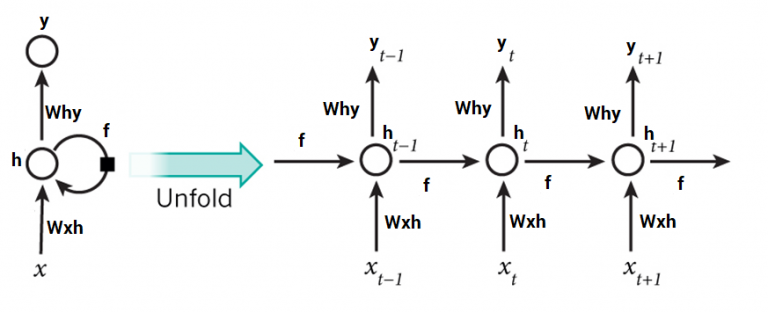


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 400, 50)           6784550   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 400, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 400, 256)          314368    
_________________________________________________________________
lstm_2 (LSTM)                (None, 400, 128)          197120    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_12 (Dense)             (None, 256)               16640     
__________

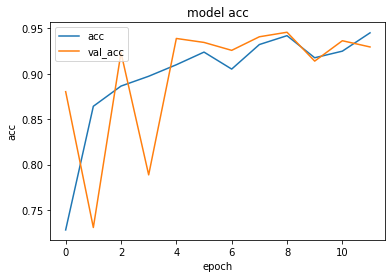

RNN-LSTM, Word Embeddings 0.9463840399002493
[[1136   72]
 [  14  382]]


In [46]:
def create_rnn_lstm():
    
    # Add an Input Layer
    input_layer = layers.Input((maxlen, ))

    # Add the word embedding Layer
    
    embedding_layer = BDTD_word2vec_50.wv.get_keras_embedding(train_embeddings=True)(input_layer)
    
    #embedding_layer = layers.Embedding(len(word_index) + 1,
    #                                   emb_dimension,
    #                                   weights=[embedding_matrix],
    #                                   trainable=False)(input_layer)
    
    embedding_layer = layers.SpatialDropout1D(0.05)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer_1 = layers.LSTM(256, return_sequences=True)(embedding_layer) #return_sequences=True
    lstm_layer_2 = layers.LSTM(128, return_sequences=True)(lstm_layer_1)
    lstm_layer_3 = layers.LSTM(64)(lstm_layer_2)

    # Add the output Layers
    output_layer1 = layers.Dense(256, activation="relu")(lstm_layer_3)
    output_layer1 = layers.Dropout(0.2)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

classifier = create_rnn_lstm()
accuracy, confusion = train_model(classifier, train_seq_x, train_y, test_seq_x, is_neural_net=True)
print ("RNN-LSTM, Word Embeddings",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())

**3.7.3 Recurrent Neural Network – GRU**  
Gated Recurrent Units are another form of recurrent neural networks. Lets add a layer of GRU instead of LSTM in our network.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 400, 50)           6784550   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 400, 50)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 400, 20)           4260      
_________________________________________________________________
gru_2 (GRU)                  (None, 20)                2460      
_________________________________________________________________
dense_14 (Dense)             (None, 50)                1050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
__________

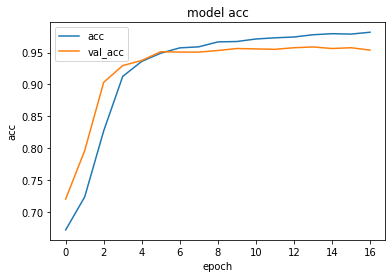

RNN-GRU, Word Embeddings 0.9576059850374065
[[1126   44]
 [  24  410]]


In [47]:
def create_rnn_gru():
    # Add an Input Layer
    input_layer = layers.Input((maxlen, ))

    # Add the word embedding Layer
    embedding_layer = BDTD_word2vec_50.wv.get_keras_embedding(train_embeddings=True)(input_layer)
    
    #embedding_layer = layers.Embedding(len(word_index) + 1,
    #                                   emb_dimension,
    #                                   weights=[embedding_matrix],
    #                                   trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.05)(embedding_layer)

    # Add the GRU Layer
    gru_layer = layers.GRU(20, return_sequences=True)(embedding_layer)
    gru_layer_1 = layers.GRU(20)(gru_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="sigmoid")(gru_layer_1)
    output_layer1 = layers.Dropout(0.2)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

classifier = create_rnn_gru()
accuracy, confusion = train_model(classifier, train_seq_x, train_y, test_seq_x, is_neural_net=True)
print ("RNN-GRU, Word Embeddings",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())

**3.7.4 Bidirectional RNN**  
RNN layers can be wrapped in Bidirectional layers as well. Lets wrap our GRU layer in bidirectional layer.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 400, 50)           6784550   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 400, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                8520      
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 51        
Total para

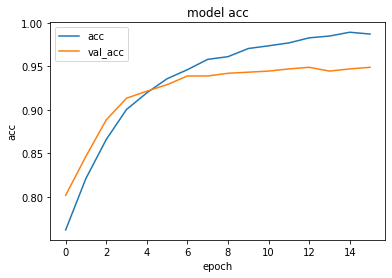

RNN-Bidirectional, Word Embeddings 0.940149625935162
[[1113   59]
 [  37  395]]


In [48]:
def create_bidirectional_rnn():
    # Add an Input Layer
    input_layer = layers.Input((maxlen, ))

    # Add the word embedding Layer
    embedding_layer = BDTD_word2vec_50.wv.get_keras_embedding(train_embeddings=True)(input_layer)
    
    #embedding_layer = layers.Embedding(len(word_index) + 1,
    #                                   emb_dimension,
    #                                   weights=[embedding_matrix],
    #                                   trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.05)(embedding_layer)

    # Add the GRU Layer
    lstm_layer = layers.Bidirectional(layers.GRU(20))(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.2)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

classifier = create_bidirectional_rnn()
accuracy, confusion = train_model(classifier, train_seq_x, train_y, test_seq_x, is_neural_net=True)
print ("RNN-Bidirectional, Word Embeddings",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())

**3.7.5 Recurrent Convolutional Neural Network**  
Once the essential architectures have been tried out, one can try different variants of these layers such as recurrent convolutional neural network. Another variants can be:  

* Hierarichial Attention Networks
* Sequence to Sequence Models with Attention
* Bidirectional Recurrent Convolutional Neural Networks
* CNNs and RNNs with more number of layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 400, 50)           6784550   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 400, 50)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 398, 100)          15100     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
__________

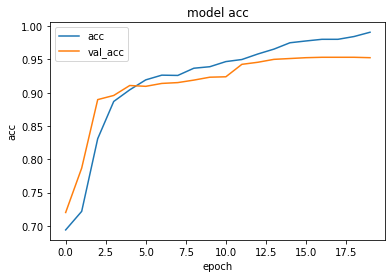

RCNN, Word Embeddings 0.9544887780548629
[[1127   50]
 [  23  404]]


In [49]:
def create_rcnn():
    # Add an Input Layer
    input_layer = layers.Input((maxlen, ))

    # Add the word embedding Layer
    embedding_layer = BDTD_word2vec_50.wv.get_keras_embedding(train_embeddings=True)(input_layer)
    #embedding_layer = layers.Embedding(len(word_index) + 1,
    #                                   emb_dimension,
    #                                   weights=[embedding_matrix],
    #                                   trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.05)(embedding_layer)
    
    # Add the recurrent layer
    rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="sigmoid")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="sigmoid")(pooling_layer)
    output_layer1 = layers.Dropout(0.2)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

classifier = create_rcnn()
accuracy, confusion = train_model(classifier, train_seq_x, train_y, test_seq_x, is_neural_net=True)
print ("RCNN, Word Embeddings",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())

**3.7.5 Bidirectional LSTM with attention mechanism** 

You can use the final encoded state of a recurrent neural network for prediction. This could lose some useful information encoded in the previous steps of the sequence. In order to keep that information, you can use an average of the encoded states outputted by the RNN. But all of the encoded states of the RNN are equally valuable. Thus, we are using a weighted sum of these encoded states to make our predicti

In [54]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
 
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

In [69]:
class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self.trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

We compute these attention weights simply by building a small fully connected neural network on top of each encoded state. This network will have a single unit final layer which will correspond to the attention weight we will assign.

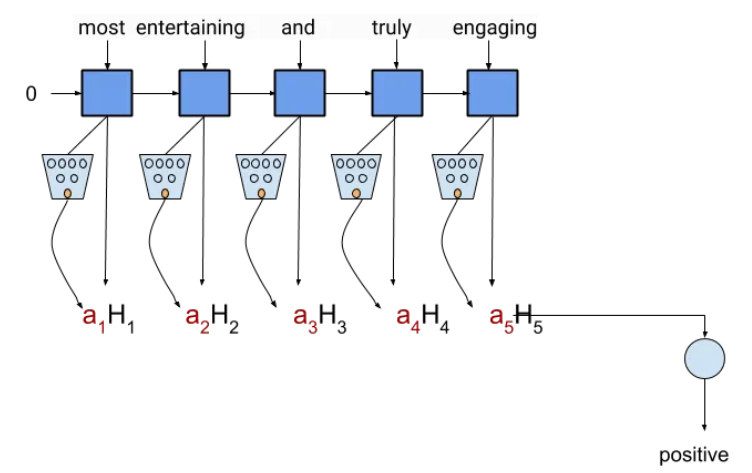

Attention function is very simple, it’s just dense layers back to back softmax. so basically a three-layer neural network density.

We will use a bi-directional RNN. This is simply the concatentation of two RNNs, one which processes the sequence from left to right (the “forward” RNN) and one which process from right to left (the “backward” RNN). By using both directions, we get a stronger encoding as each word can be encoded using the context of its neighbors on boths sides rather than just a single side. 

In [86]:
import tensorflow as tf
from keras.layers import Attention 

def create_bidirectional_attention_rnn():
    # Add an Input Layer
    input_layer = layers.Input((maxlen, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1,
                                       emb_dimension,
                                       input_length=maxlen,
                                       weights=[embedding_matrix],
                                       trainable=False)(input_layer)
    
    embedding_layer = layers.SpatialDropout1D(0.05)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.Bidirectional(layers.LSTM(256,
                                                  dropout=0.5,
                                                  return_sequences=True,
                                                  return_state=True,
                                                  recurrent_activation='relu',
                                                  recurrent_initializer='glorot_uniform'))(embedding_layer)
    
    # Attention Layer
    attention_layer = layers.Attention()(lstm_layer)

     
    # Output layer
    output = layers.Dense(1, activation='sigmoid')(attention_layer)
    
    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

classifier = create_bidirectional_attention_rnn()
accuracy, confusion = train_model(classifier, train_seq_x, train_y, test_seq_x, is_neural_net=True)
print ("RNN-Bidirectional, Word Embeddings",  accuracy)
with tf.Session() as sess:
    print(confusion.eval())

ImportError: cannot import name 'Attention'